In [1]:
import wikipedia
import wikipediaapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
import string

# Data Cleaning

In [2]:
## take all article in category (max_level control the depthness of articles taken from the subcategories)
def print_categorymembers(categorymembers, level=0, max_level=1):
    list_articles = []
    for c in categorymembers.values():
        if c.ns == 0:
            list_articles.append(c) 
            ##print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
        elif level < max_level and c.ns == 14:
            sub_list = []
            sub_list = print_categorymembers(c.categorymembers, level=level + 1, max_level=max_level)
            list_articles = list_articles + sub_list
    return list_articles

In [3]:
wiki_wiki = wikipediaapi.Wikipedia('en')
cat1 = wiki_wiki.page("Category:Religion")
cat2 = wiki_wiki.page("Category:Science")

In [4]:
religion_articles = print_categorymembers(cat1.categorymembers)
science_articles = print_categorymembers(cat2.categorymembers)

## This cell is about the hyperlink of articles but not relevant anymore

In [ ]:
## Create the adjacency matrix
def make_links(list_articles):
    matrix = np.zeros((len(list_articles), len(list_articles)))
    compt = 0
    for article in list_articles:
        for link in article.links:
            for i in range(len(list_articles)):
                if (link == list_articles[i].title):
                    matrix[compt,i] = 1
    return matrix
adjacency_matrix = make_links(list_articles)
num_edges = np.count_nonzero(adjacency_matrix)
print(f"Number of edges in the feature graph: {num_edges}")

In [7]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lilia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lilia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
#Take all the words present in the articles that are not stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop1 = ['====', '===', '==', '<<', '>>', "''", '``', "'s" , '\displaystyle', '...', '\phi', '\mu', '\mathbf', '--', 'x_',
        '\alpha', '\dot', '\hat', '\lambda', '\left', '\right', 'matcal', '\nu', '\partial']
stop2 = stopwords.words('english')
stop = stop1+stop2
wikipedia.set_lang('en')

def take_words(list_articles) :
    words_df = pd.DataFrame(columns=['article', 'words'])
    for i in range(len(list_articles)):
        if (i%100 == 0) :
            print(i)
        try: 
            page = wikipedia.page(list_articles[i].title)
        except wikipedia.DisambiguationError as e:
            s = e.options
            s = list(filter(lambda x : x != "", s))
            try :
                page = wikipedia.page(s)
            except wikipedia.DisambiguationError as e:
                pass
        except wikipedia.PageError:
            pass
        words = word_tokenize(page.content)
        words = [elem.lower() for elem in words]
        words = [elem for elem in words if len(elem) > 1 and elem.isdigit() == False]
        words_wostop = [x for x in words if x not in stop]
        words_wostop = [elem.lower() for elem in words_wostop]
        words_df.loc[i] = [list_articles[i].title] + [words_wostop]
    return words_df

In [9]:
#religion_df = take_words(religion_articles)

In [10]:
#religion_df.to_pickle('religion_articles')

In [11]:
religion_df = pd.read_pickle('religion_articles')

In [12]:
#science_df = take_words(science_articles)

In [13]:
#science_df.to_pickle('science_articles')

In [14]:
science_df = pd.read_pickle('science_articles')

In [15]:
labels_df = pd.DataFrame(columns = ['title', 'label'])
for i in range(len(religion_df)):
    labels_df.loc[i] = [religion_df['article'].iloc[i]] + [0]
for j in range(len(religion_df), len(religion_df) + len(science_df)):
    labels_df.loc[j] = [science_df['article'].iloc[j-len(religion_df)]] + [1]  
labels_df = labels_df.drop_duplicates('title')

In [16]:
words_df = pd.concat([religion_df, science_df])

### Manual TF-IDF 

In [118]:
TF_religion = religion_df.explode('words')
len_religion = len(TF_religion)
TF_science = science_df.explode('words')
len_science = len(TF_science)

In [119]:
TF_religion = TF_religion.groupby(['words']).count().reset_index().sort_values(['article'], ascending = False)
TF_religion['TF'] = TF_religion['article'].apply(lambda x : x/len_religion)
TF_science = TF_science.groupby(['words']).count().reset_index().sort_values(['article'], ascending = False)
TF_science['TF'] = TF_science['article'].apply(lambda x : x/len_science)

In [120]:
import math
IDF = words_df.explode('words').groupby(['words']).count().reset_index().sort_values(['article'], ascending = False)

In [121]:
IDF

,words,article
104812,science,20074
15846,also,15661
85994,one,12190
99823,religion,11062
99904,religious,11056
...,...,...
38494,design.in,1
38499,design/layout,1
38512,designin,1
38516,design—namely,1


In [122]:
# IDF is the log of the number of documents divided by the number of documents that contain the word w
IDF['IDF'] = IDF['article'].apply(lambda x : math.log(len(IDF)/x))
IDF

,words,article,IDF
104812,science,20074,1.888055
15846,also,15661,2.136307
85994,one,12190,2.386864
99823,religion,11062,2.483965
99904,religious,11056,2.484507
...,...,...,...
38494,design.in,1,11.795236
38499,design/layout,1,11.795236
38512,designin,1,11.795236
38516,design—namely,1,11.795236


In [111]:
TF_IDF_religion = TF_religion.merge(IDF, on = ['words']).drop(['article_x', 'article_y'], axis = 1)
TF_IDF_religion['TF_IDF'] = TF_IDF_religion['TF']*TF_IDF_religion['IDF']
TF_IDF_science = TF_science.merge(IDF, on = ['words']).drop(['article_x', 'article_y'], axis = 1)
TF_IDF_science['TF_IDF'] = TF_IDF_science['TF']*TF_IDF_science['IDF']

In [112]:
important_words_df = pd.concat([TF_IDF_religion.sort_values(['TF_IDF'], ascending = False).head(500),TF_IDF_science.sort_values(['TF_IDF'], ascending = False).head(500)])

In [113]:
important_words_df = important_words_df.drop_duplicates(subset = ['words'])

In [114]:
important_words_df.sort_values(['TF_IDF'], ascending = False)

,words,TF,IDF,TF_IDF
0,science,0.008757,1.888055,0.016533
2,scientific,0.004320,2.636504,0.011388
3,research,0.003981,2.667842,0.010619
1,also,0.004351,2.136307,0.009295
5,used,0.002736,2.873378,0.007861
...,...,...,...,...
45724,.different,0.000001,11.102088,0.000014
21561,աջապան,0.000001,11.102088,0.000014
21531,tunguz,0.000001,11.102088,0.000014
45702,.jews,0.000001,11.102088,0.000014


In [221]:
explode_df = words_df.explode('words')
explode_df['exist'] = np.ones(len(explode_df))
df = pd.DataFrame(words_df['article']).assign(key = 1).merge(pd.DataFrame(important_words_df['words']).assign(key = 1), on = 'key').drop('key', 1)
df2 = df.merge(explode_df, on = ['article','words'] , how = 'left').drop_duplicates().fillna(0)
df3 = pd.pivot_table(df2, values = 'exist',  index = 'article', columns=['words'])
df3

words,ability,able,academic,academy,access,according,act,action,activities,acupuncture,...,worship,would,writing,written,wrote,year,years,yoga,york,young
article,,,,,,,,,,,,,,,,,,,,,
1888–1893 Uprisings of Hazaras,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2003 Quetta mosque bombing,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2004 Quetta Ashura massacre,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017–19 Iranian protests against compulsory hijab,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
2019 Indian Science Congress pseudoscience controversies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero balancing,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Zmanim,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
Zoetron therapy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### sickit TF-IDF

In [17]:
#remove strings like "10,000"
#religion_df['words'] = religion_df['words'].apply(lambda word_list: list(filter(lambda word: (',' not in word), word_list)))
#only keep strings that contain alphabet chars
religion_df['words'] = religion_df['words'].apply(lambda word_list: list(filter(lambda word: word.isalpha(), word_list)))
# create a column with all words concatenated
religion_df['words_string'] = religion_df['words'].apply(lambda words_list: " ".join(words_list))

# tfidf
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(religion_df['words_string'])
feature_names = vectorizer.get_feature_names()
#dense = vectors.todense()
#denselist = dense.tolist()

#tf_idf_religion = pd.DataFrame(denselist, columns=feature_names, index = religion_df['article'])
#tf_idf_religion.to_pickle('tf_idf_religion')
tf_idf_religion = pd.read_pickle('tf_idf_files/tf_idf_religion')
tf_idf_religion

,aa,aaa,aaaaaaah,aaan,aabco,aacharya,aachen,aadt,aaetpio,aafia,...,龍母,龍王,龍神,공식,그리스도,기독교도,보천교,증산도,홈페이지,𐭦𐭭𐭣𐭩𐭪
article,,,,,,,,,,,,,,,,,,,,,
Religion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
African and African-American women in Christianity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Religion and agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
American Anglican Church,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
American Humanist Association,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trinidad Orisha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Utaki,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Votive site,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#remove strings like "10,000"
#science_df['words'] = science_df['words'].apply(lambda word_list: list(filter(lambda word: (',' not in word), word_list)))
#only keep strings that contain alphabet chars
science_df['words'] = science_df['words'].apply(lambda word_list: list(filter(lambda word: word.isalpha(), word_list)))
# create a column with all words concatenated
science_df['words_string'] = science_df['words'].apply(lambda words_list: " ".join(words_list))

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(science_df['words_string'])
feature_names = vectorizer.get_feature_names()
#dense = vectors.todense()
#denselist = dense.tolist()

#tf_idf_science = pd.DataFrame(denselist, columns=feature_names, index = science_df['article'])
#tf_idf_science.to_pickle('tf_idf_science')
tf_idf_science = pd.read_pickle('tf_idf_files/tf_idf_science')
tf_idf_science

,aa,aaa,aaaai,aaadietya,aaai,aaas,aab,aaboe,aac,aacap,...,黄耆,黄芪,黄连,黄連,龍門八法,삼칠일,윤종수,ﬁrst,𐎠𐎼𐎡𐎹,𓆎𓅓𓏏𓊖
article,,,,,,,,,,,,,,,,,,,,,
Science,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013136,0.0,0.0
Outline of science,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Branches of science,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Invention,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Logical reasoning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wiggle matching,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Wigner lattice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Wiley mill,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [74]:
#Source : http://ethen8181.github.io/machine-learning/clustering/tfidf/tfidf.html
from sklearn.neighbors import NearestNeighbors

#Let's look at the k nearest neighbours of the first article
nn = NearestNeighbors(metric = 'euclidean')
nn.fit(vectors)
distances, indices = nn.kneighbors(vectors[0], n_neighbors = 10)

# 1. flatten the 2d-array distance and indices to 1d
# 2. merge the distance information with the original wiki dataset, 
#    to obtain the name matching the id.
neighbors = pd.DataFrame({'distance': distances.flatten(), 'id': indices.flatten()})
nearest_info = (science_df.
                merge(neighbors, right_on = 'id', left_index = True).
                sort_values('distance')[['id', 'article', 'distance']])
nearest_info


,id,article,distance
0,0,Science,0.000000
1,10,Natural science,0.914844
2,1224,Philosophy of science,0.936022
4,1,Outline of science,0.936677
3,12,Outline of science,0.936677
6,2,Branches of science,0.983497
5,7,Branches of science,0.983497
7,541,History of scientific method,1.021829
8,574,Logology (science),1.022673
9,540,Scientific method,1.026716


In [49]:
from collections import Counter

def unpack_word_weight(vect, word_weight):
    """
    Given the CountVector and the fit_transformed
    word count sparse array obtain each documents' 
    word count dictionary
    
    In the Compressed Sparse Row format,
    `indices` stands for indexes inside the row vectors of the matrix 
    and `indptr` (index pointer) tells where the row starts in the data and in the indices 
    attributes. nonzero values of the i-th row are data[indptr[i]:indptr[i+1]] 
    with column indices indices[indptr[i]:indptr[i+1]]
    
    References
    ----------
    http://www.scipy-lectures.org/advanced/scipy_sparse/csr_matrix.html
    """
    feature_names = np.array(vect.get_feature_names())
    data = word_weight.data
    indptr = word_weight.indptr
    indices = word_weight.indices
    n_docs = word_weight.shape[0]
    
    word_weight_list = []
    for i in range(n_docs):
        doc = slice(indptr[i], indptr[i + 1])
        count, idx = data[doc], indices[doc]
        feature = feature_names[idx]
        word_weight_dict = Counter({k: v for k, v in zip(feature, count)})
        word_weight_list.append(word_weight_dict)
    
    return word_weight_list

science_df['word_weight'] = unpack_word_weight(vectorizer, vectors)
science_df.head(3)

,article,words,words_string,word_weight
0,Science,"[science, latin, word, scientia, meaning, know...",science latin word scientia meaning knowledge ...,"{'paleontology': 0.008470663825089975, 'museum..."
1,Outline of science,"[following, outline, provided, topical, overvi...",following outline provided topical overview sc...,"{'virtual': 0.010233928185281661, 'website': 0..."
2,Branches of science,"[branches, science, also, referred, sciences, ...",branches science also referred sciences scient...,"{'footnotes': 0.017310442868079104, 'moral': 0..."


In [63]:
def get_top_words(wiki_df, name, column_name, top_n = None):
    row = wiki_df.loc[wiki_df['article'] == name, column_name]

    # when converting Series to dictionary, the row index 
    # will be the key to the content
    word_weight_dict = row.to_dict()[row.index[0]]
    
    if top_n is None:
        top_n = len(word_weight_dict)
    
    word_weight_table = pd.DataFrame(word_weight_dict.most_common(top_n), 
                                     columns = ['word', 'weight'])
    return word_weight_table


In [64]:
words_science = get_top_words(science_df, name = 'Science', column_name = 'word_weight')
words_natural_science = get_top_words(science_df, name = 'Natural science', column_name = 'word_weight')
# merge the two DataFrame, since both tables contained the same column name weight, 
# it will automatically renamed one of them by adding suffix _x and _y to prevent confusion.
# hence we'll rename the columns to tell which one is for which
words_combined = (words_science.
                  merge(words_natural_science, on = 'word').
                  rename(columns = {'weight_x': 'Science', 'weight_y': 'Natural Science'}))
words_combined.head(6)

,word,Science,Natural Science
0,science,0.376586,0.246270
1,scientific,0.253715,0.111370
2,natural,0.175084,0.445040
3,knowledge,0.171888,0.016168
4,research,0.149307,0.023131
5,sciences,0.138772,0.238121


In [47]:
features = df3.drop('article', axis = 1).values

In [48]:
np.sum(features, axis = 1)

array([110., 144.,  92., ...,  44., 155., 236.])

# Graph

In [49]:
distances = np.array([[(np.sum((features[i,:]-features[j,:])**2)) for i in range(0,features.shape[0]) ] for j in range(0,features.shape[0])]).reshape(features.shape[0],-1)

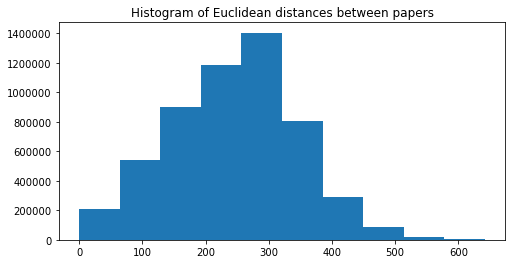

In [50]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distances.flatten());

In [129]:
feat = distances/np.max(distances)
np.fill_diagonal(feat, 0)

In [130]:
graph = nx.from_numpy_matrix(feat)

In [131]:
giant_feature = max(nx.connected_component_subgraphs(graph), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 2333 nodes and 2719618 edges.


In [ ]:
nx.average_clustering(graph)

In [132]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    adjacency = squareform(pdist(X))
    adjacency = np.exp((- adjacency**2)/(2 * sigma**2))
    adjacency[adjacency < epsilon] = 0
    #according to the formula on slide 11 in the spectral clustering lecture, we set the diagonal to 0
    np.fill_diagonal(adjacency,0)
    return adjacency

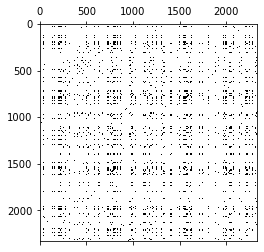

In [143]:
from scipy.spatial.distance import pdist, squareform
adjacency = epsilon_similarity_graph(feat, sigma= 4*np.mean(feat), epsilon=0.75)
plt.spy(adjacency)
plt.show()

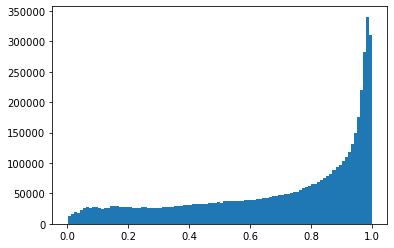

In [142]:
temp = np.exp((- squareform(pdist(feat))**2)/(2 * (1.5 * np.median(pdist(feat)))**2))
plt.hist(temp.flatten(),bins=100);

In [ ]:
import operator
pr = nx.pagerank(graph)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse = True)

In [ ]:
sorted_pr[:10]

In [ ]:
list_articles[794]

In [64]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    degrees_l = np.sum(adjacency,axis=1)
    if(not normalize):
        degrees = np.zeros(adjacency.shape)
        np.fill_diagonal(degrees,degrees_l)
        return degrees - adjacency 
    else:
        degrees = np.sqrt(np.array([degrees_l]).T @ np.array([degrees_l]))
        L = - adjacency/degrees
        np.fill_diagonal(L,np.ones(len(adjacency)))
        return L

In [65]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    values, vectors = np.linalg.eig(laplacian)
    sorted_indices = np.argsort(values)
    return values[sorted_indices], vectors[:,sorted_indices]
    # Your code here

In [146]:
laplacian = compute_laplacian(feat, normalize=True)
lam, U = spectral_decomposition(np.nan_to_num(laplacian))

In [147]:
def GFT(signal: np.ndarray):
    fourier = U.transpose()@signal
    return fourier

def iGFT(fourier_coefficients: np.ndarray):
    signal = U@fourier_coefficients
    return signal

In [148]:
alpha = 0.99 / np.max(lam)

ideal_tk =  1/(1 + alpha*lam)

In [149]:
def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
    """Return a filtered signal."""
    fourier = GFT(x);
    h = np.diag(spectral_response)
    filtered_graph = U@h@fourier
    return filtered_graph

In [151]:
filt = ideal_graph_filter(adjacency.tolist(),ideal_tk)

In [152]:
np.fill_diagonal(filt, 0)

In [153]:
filt

array([[ 0.        +0.00000000e+00j, -0.10735224-1.25360876e-19j,
        -1.00984929-5.42101086e-20j, ...,  0.21941671-4.33680869e-19j,
         0.02876598+2.03287907e-20j,  0.        +0.00000000e+00j],
       [ 0.94270558+1.30104261e-18j,  0.        +0.00000000e+00j,
        -0.18888424-1.73472348e-18j, ..., -1.2701307 +4.33680869e-19j,
        -0.03529141+0.00000000e+00j,  0.        +0.00000000e+00j],
       [-1.08020453+4.33680869e-19j,  0.42779613-1.08420217e-19j,
         0.        +0.00000000e+00j, ...,  0.45675636+1.51788304e-18j,
         0.11257711-8.13151629e-20j,  0.        +0.00000000e+00j],
       ...,
       [ 0.02799933+0.00000000e+00j,  0.01224317+2.71050543e-19j,
         0.37429042+0.00000000e+00j, ...,  0.        +0.00000000e+00j,
         0.00963339+0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 0.04650732+2.16840434e-19j,  0.10951179-2.16840434e-19j,
        -0.07553162-2.16840434e-19j, ...,  0.28332946+1.24683250e-18j,
         0.        +0.00000000e+00j

In [101]:
graph_filt = nx.from_numpy_matrix(filt)

In [74]:
pr = nx.pagerank(graph_filt)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse = True)

KeyboardInterrupt: 

In [ ]:
sorted_pr[:10]

In [ ]:
list_articles[296]

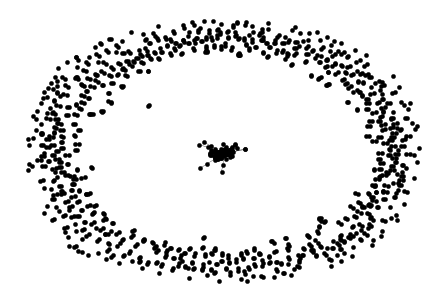

In [102]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph, **options)

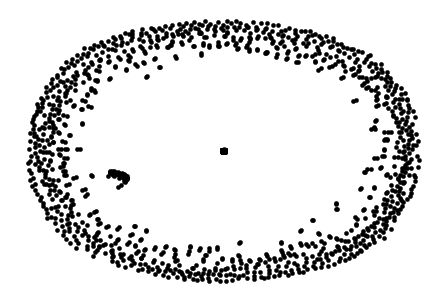

In [103]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph_filt, **options)

In [107]:
giant_features = max(nx.connected_component_subgraphs(graph_filt), key = len)

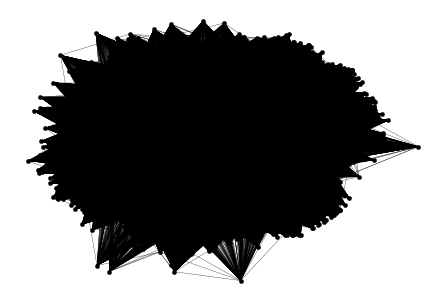

In [108]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(giant_features, **options)

In [110]:
giant_features.nodes

NodeView((2050, 3, 2051, 5, 7, 8, 9, 10, 11, 12, 13, 14, 2056, 2060, 2062, 18, 19, 20, 2063, 22, 2066, 24, 25, 26, 27, 2072, 2073, 2075, 2079, 32, 2080, 34, 35, 36, 2082, 38, 39, 2083, 41, 42, 43, 2091, 45, 2092, 47, 2094, 49, 50, 2096, 2098, 2099, 2100, 55, 56, 57, 58, 2101, 60, 61, 2102, 63, 64, 2104, 66, 2113, 68, 69, 70, 2115, 72, 2116, 74, 2118, 2121, 77, 2122, 79, 2123, 2125, 2127, 2128, 84, 2131, 86, 2132, 2133, 89, 90, 2136, 92, 93, 94, 95, 96, 97, 2137, 99, 2139, 101, 102, 103, 104, 2144, 2145, 107, 2147, 109, 110, 2153, 112, 2154, 2157, 115, 116, 117, 118, 2158, 120, 2160, 2161, 123, 124, 125, 126, 127, 128, 2168, 130, 131, 2172, 2174, 2175, 135, 136, 137, 2177, 139, 140, 2180, 142, 2187, 144, 145, 146, 2188, 2189, 2190, 2191, 151, 152, 2193, 154, 2194, 156, 2196, 158, 2198, 160, 2203, 2204, 2207, 164, 165, 2211, 2215, 169, 2218, 2221, 174, 175, 176, 2222, 2223, 2224, 2226, 2228, 182, 2229, 184, 185, 2231, 187, 2235, 190, 2238, 2240, 194, 195, 2244, 198, 2247, 200, 202, 203, 

In [116]:
def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
    """ Return:
        coords (n x dim array): new coordinates for the data points."""
    adjacency = epsilon_similarity_graph(X, sigma, epsilon)
    laplacian = compute_laplacian(adjacency, normalize)
    eigenvalues, eigenvectors = spectral_decomposition(np.nan_to_num(laplacian)) 
    return (eigenvectors[:,1:dim+1])

In [156]:
twoD_embeddings = laplacian_eigenmaps(feat, dim=2, sigma= 4*np.mean(feat), epsilon=0.75, normalize=True)

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


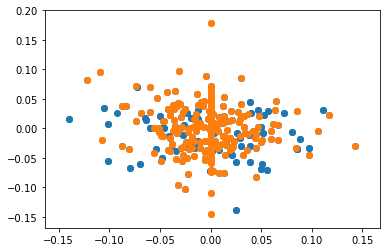

In [157]:
plt.scatter(twoD_embeddings[0:800,0], twoD_embeddings[0:800,1], label=1)
plt.scatter(twoD_embeddings[800:2650,0], twoD_embeddings[800:2650,1], label=2)

In [158]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
x_embed = tsne.fit_transform(feat)

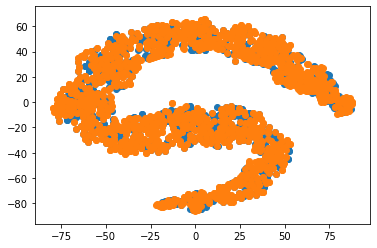

In [159]:
plt.scatter(x_embed[0:800,0], x_embed[0:800,1], label=1)
plt.scatter(x_embed[800:2650,0], x_embed[800:2650,1], label=2)

In [321]:
graph = nx.from_numpy_matrix(feat)

In [338]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl import DGLGraph
import dgl.function as fn

np.random.seed(0)
torch.manual_seed(1)

In [180]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

In [330]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [322]:
from sklearn.model_selection import train_test_split
x1, x2, y1, y2, idx1, idx2 = train_test_split(
    filt, labels_df['label'], range(filt.shape[1]), test_size=0.4)
x3, x4, y3, y4, idx3, idx4 = train_test_split(
    x2, y2, idx2, test_size=0.5)

In [323]:
train_df = pd.DataFrame(np.column_stack((idx1, np.ones(len(idx1)).T)), columns = ['idx', 'indices'])
train = labels_df.merge(train_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
val_df = pd.DataFrame(np.column_stack((idx3, np.ones(len(idx3)).T)), columns = ['idx', 'indices'])
val = labels_df.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
test_df = pd.DataFrame(np.column_stack((idx4, np.ones(len(idx4)).T)), columns = ['idx', 'indices'])
test = labels_df.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)

In [340]:
in_feats = filt.shape[1]
n_classes = 2
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 100
p_dropout = 0.8
features = torch.FloatTensor(feat) 
labels = torch.LongTensor(labels_df['label']) 
train_mask = torch.BoolTensor(train['indices'])
val_mask = torch.BoolTensor(val['indices'])
test_mask = torch.BoolTensor(test['indices'])

TypeError: 'function' object is not subscriptable

In [ ]:
train_mask.shape

In [ ]:
model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

graph = DGLGraph(graph)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

In [333]:
coeff_gcn =  model.pol_weights.data.numpy()
print(coeff_gcn)

AttributeError: 'Graph' object has no attribute 'local_var'

In [ ]:
plt.semilogy(lam, np.abs(polynomial_graph_filter_response(coeff_gcn, lam)))
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response (db)')